# Credit Card Fraud Detection

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning import seed_everything
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import Normalizer, minmax_scale
from torch.utils.data import (BatchSampler, DataLoader, Dataset, RandomSampler,
                              SequentialSampler, TensorDataset)

warnings.filterwarnings("ignore")

## 1. Loading in data and setup

In [2]:
df = pd.read_csv('../data/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
df.shape

(284807, 31)

In [5]:
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

<Axes: xlabel='Class', ylabel='count'>

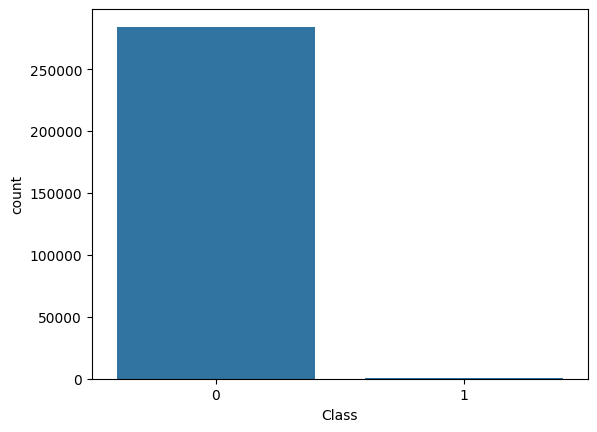

In [6]:
sns.countplot(x = 'Class', data = df)

We have huge class imbalance here: only 0.17% of the samples is credit card fraud. We will keep this in mind as we later implement binary classification.

In [7]:
SEED = 42
seed_everything(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Selected device is", DEVICE)

Seed set to 42


Selected device is cpu


In [8]:
missing_col_count = 0
for col in df.columns:
    missings = df[col].isnull().sum()
    if missings > 1:
        print(col, ':', missings)
        missing_col_count += 1
print(f'Total number of columns with missing values: {missing_col_count}')

Total number of columns with missing values: 0


## 2. Data preprocessing

In [9]:
df.Time.describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

We will make a time-series split: we take the samples up to 75th percentile of time as the training set.

In [10]:
time_split_point = 139_320

df_train = df.loc[df.Time <= time_split_point].drop(columns='Time')
df_test = df.loc[df.Time > time_split_point].drop(columns='Time')

y_train = df_train.Class
y_test = df_test.Class

X_train = df_train.drop(columns='Class')
X_test = df_test.drop(columns='Class')

The features are V1, V2, V3 etc, probably because they are transformed features or embeddings, as the results of dimensionality reduction or transformation. Therefore, we will normalize each sample vector to have unit norm.

In [12]:
normalizer = Normalizer()
normalizer.fit(X_train)

X_train = normalizer.transform(X_train)
X_test = normalizer.transform(X_test)

X_train.shape, y_train.shape

((213605, 29), (213605,))

We also need to convert the data into tensor format, which is expected by PyTorch.

In [13]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=DEVICE)

y_train_tensor = torch.tensor(df_train['Class'].values, dtype=torch.long, device=DEVICE)
y_test_tensor = torch.tensor(df_test['Class'].values, dtype=torch.long, device=DEVICE)

X_train_tensor.shape, X_test_tensor.shape

(torch.Size([213605, 29]), torch.Size([71202, 29]))

## 3. Unsupervised fraud detection

### 3.1. Baseline: Isolation Forest

We will first use Isolation Forest, an unsupervised learning technique that is based on Random Forest idea. Isolation Forest made completely random splits instead of on entropy-driven basis. It calculates anomalous score by looking at the number of steps that it takes to isolate a sample. The fewer steps it takes to isolate the sample, the higher change that it is an outlier and thus, an anomaly.

In [16]:
ifor = IsolationForest(n_estimators=100, random_state=42)
ifor.fit(X_train)

ifor_preds_train = ifor.score_samples(X_train)
ifor_preds_test = ifor.score_samples(X_test)

Isolation Forest AUC = 0.6516070400553429


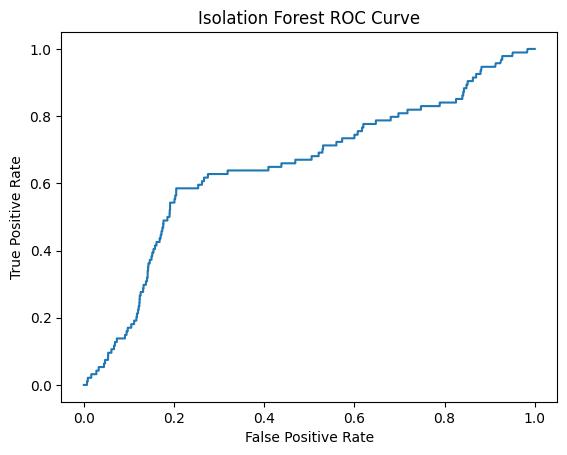

In [17]:
fpr_if, tpr_if, _ = roc_curve(y_test, 1 - minmax_scale(ifor_preds_test))
print("Isolation Forest AUC =", auc(fpr_if, tpr_if))

plt.plot(fpr_if, tpr_if)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Isolation Forest ROC Curve")
plt.grid(False)
plt.show()

### 3.2. Autoencoder

Next, we train an autoencoder. The reconstruction loss of the autoencoder tells us: how well our network is able to reconstruct each sample. So, if there are samples with which our network struggles to reconstruct, indicated by high MSE, this will probably indicate that the samples are outliers.

In [18]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.Tanh(),
            nn.Dropout(0.25),
            nn.Linear(16, 8),
            nn.Tanh(),
            nn.Dropout(0.25)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.Tanh(),
            nn.Dropout(0.25),
            nn.Linear(16, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

In [19]:
batch_size = 512

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=batch_size, shuffle=False)

In [20]:
input_dim = X_train_tensor.shape[1]
learning_rate = 0.001
model = Autoencoder(input_dim=input_dim).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x = batch[0]
        output = model(x)
        loss = criterion(output, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Avergage loss: {avg_loss:.4f}')

Epoch 1, Avergage loss: 0.0160
Epoch 2, Avergage loss: 0.0079
Epoch 3, Avergage loss: 0.0071
Epoch 4, Avergage loss: 0.0068
Epoch 5, Avergage loss: 0.0066
Epoch 6, Avergage loss: 0.0065
Epoch 7, Avergage loss: 0.0064
Epoch 8, Avergage loss: 0.0063
Epoch 9, Avergage loss: 0.0063
Epoch 10, Avergage loss: 0.0062
Epoch 11, Avergage loss: 0.0062
Epoch 12, Avergage loss: 0.0062
Epoch 13, Avergage loss: 0.0061
Epoch 14, Avergage loss: 0.0061
Epoch 15, Avergage loss: 0.0061
Epoch 16, Avergage loss: 0.0061
Epoch 17, Avergage loss: 0.0061
Epoch 18, Avergage loss: 0.0061
Epoch 19, Avergage loss: 0.0061
Epoch 20, Avergage loss: 0.0061


In [22]:
model.eval()
reconstruction_errors = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0]
        output = model(x)
        error = torch.mean((x - output) ** 2, dim=1)
        reconstruction_errors.append(error)

reconstruction_errors = torch.cat(reconstruction_errors)

Based on reconstruction score, we will simply scale the score to [0, 1] and retain the AUC and ROC curve.

Reconstruction error AUC = 0.7285974346484041


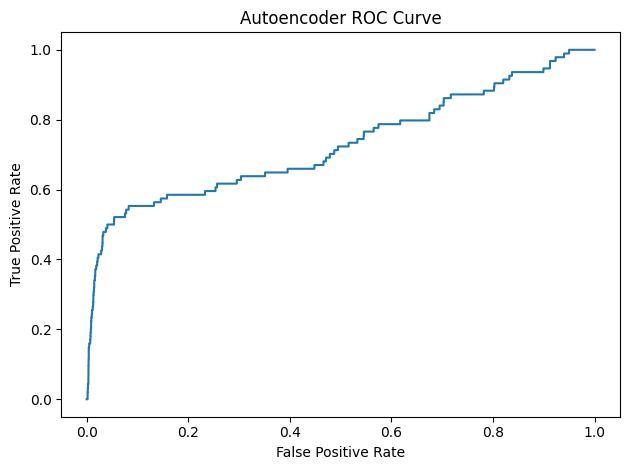

In [28]:
anomaly_scores = reconstruction_errors.cpu().numpy()
true_labels = y_test_tensor.cpu().numpy()

fpr_ae, tpr_ae, _ = roc_curve(true_labels, minmax_scale(anomaly_scores))
print('Reconstruction error AUC =', auc(fpr_ae, tpr_ae))

plt.plot(fpr_ae, tpr_ae)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Autoencoder ROC Curve")
plt.grid(False)
plt.tight_layout()
plt.show()

We get an AUC = 0.7276, which is higher than Isolation Forest. This is quite impressive, given that this is entirely unsupervised.

## 4. Supervised fraud detection

Now, we will train a number of supervised models to predict credit card fraud. The target is the binary classification labels of 0 or 1.

### 4.1. Baseline: Random Forest with original features

In [25]:
rf = RandomForestClassifier(n_estimators=100, random_state=514)
rf.fit(X_train, y_train)
rf_preds = rf.predict_proba(X_test)

Original features RF AUC = 0.931590649045683


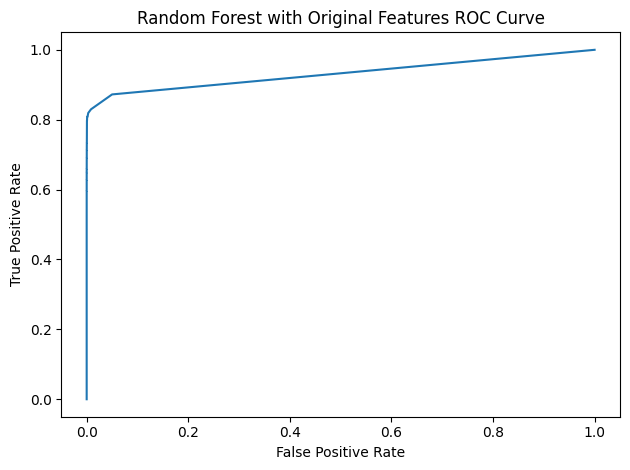

In [27]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_preds[:, 1])
print("Original features RF AUC =", auc(fpr_rf, tpr_rf))

plt.plot(fpr_rf, tpr_rf)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest with Original Features ROC Curve")
plt.grid(False)
plt.tight_layout()
plt.show()

### 4.2. Random Forest with anomaly scores

We will use anomaly scores for Isolation Forest and autoencoder as additional features and train a Random Forest on the augmented data set.

In [31]:
model.eval()
with torch.no_grad():
    pred_train = model(X_train_tensor).cpu()
    pred_test = model(X_test_tensor).cpu()

mse_train = torch.sum((X_train_tensor.cpu() - pred_train) ** 2, dim=1)
mse_test = torch.sum((X_test_tensor.cpu() - pred_test) ** 2, dim=1)

In [32]:
X_train_with_anomaly_scores = pd.DataFrame(X_train)
X_train_with_anomaly_scores = X_train_with_anomaly_scores.add_prefix('col_')
X_train_with_anomaly_scores['mse_score'] = mse_train
X_train_with_anomaly_scores['ifor_score'] = ifor_preds_train

X_test_with_anomaly_scores = pd.DataFrame(X_test)
X_test_with_anomaly_scores = X_test_with_anomaly_scores.add_prefix('col_')
X_test_with_anomaly_scores['mse_score'] = mse_test
X_test_with_anomaly_scores['ifor_score'] = ifor_preds_test

In [33]:
rf_augmented = RandomForestClassifier(n_estimators=100, random_state=514)
rf_augmented.fit(X_train_with_anomaly_scores, y_train)
rf_augmented_preds = rf_augmented.predict_proba(X_test_with_anomaly_scores)

Features with anomaly scores RF AUC = 0.9312187245293044


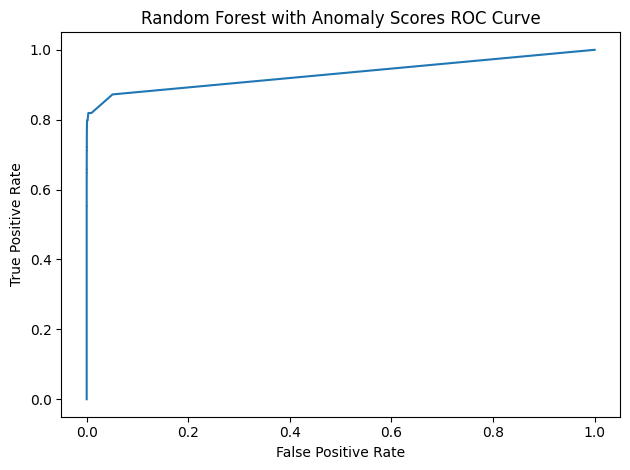

In [35]:
fpr_rf_aug, tpr_rf_aug, _ = roc_curve(y_test, rf_augmented_preds[:, 1])
print("Features with anomaly scores RF AUC =", auc(fpr_rf_aug, tpr_rf_aug))

plt.plot(fpr_rf_aug, tpr_rf_aug)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest with Anomaly Scores ROC Curve")
plt.grid(False)
plt.tight_layout()
plt.show()

The results do not improve compared to the model with only original features.

### 4.3. Random Forest with autoencoder embeddings

Now we will do another experiment: taking the embeddings from the bottle-neck layer of the autoencoder and use them as features for our Random Forest.

In [36]:
model.eval()
with torch.no_grad():
    X_train_embeddings = model.encode(X_train_tensor).cpu()
    X_test_embeddings = model.encode(X_test_tensor).cpu()

In [37]:
rf_embeddings = RandomForestClassifier(n_estimators=100, random_state=514)
rf_embeddings.fit(X_train_embeddings, y_train)
rf_embeddings_preds = rf_embeddings.predict_proba(X_test_embeddings)

Embedding with RF AUC = 0.8489839848046543


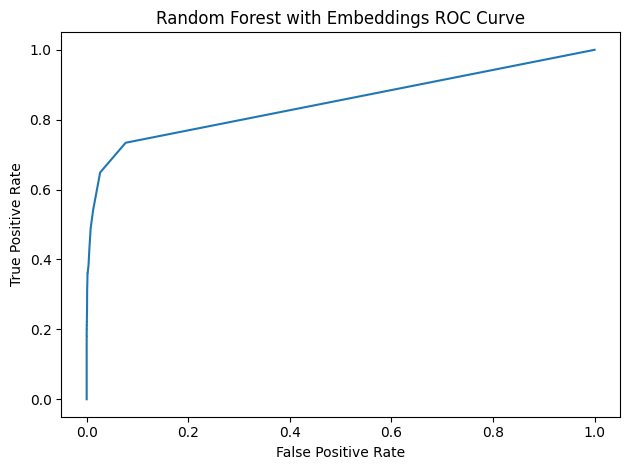

In [38]:
fpr_rf_emb, tpr_rf_emb, _ = roc_curve(y_test, rf_embeddings_preds[:, 1])
print('Embedding with RF AUC =', auc(fpr_rf_emb, tpr_rf_emb))

plt.plot(fpr_rf_emb, tpr_rf_emb)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest with Embeddings ROC Curve")
plt.grid(False)
plt.tight_layout()
plt.show()

The result is not that good. So far, Random Forest on original features remains the best model.

### 4.4. MLP

Instead of Random Forest, we can train a MLP to see if it is better at predicting the target classes.

In [39]:
class Mlp(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [40]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [43]:
input_dim = X_train_tensor.shape[1]
learning_rate = 0.001

model = Mlp(input_dim=input_dim).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        output = model(x).squeeze(1)
        loss = criterion(output, y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Average loss: {avg_loss:.4f}')

Epoch 1, Average loss: 0.1975
Epoch 2, Average loss: 0.0388
Epoch 3, Average loss: 0.0196
Epoch 4, Average loss: 0.0140
Epoch 5, Average loss: 0.0116
Epoch 6, Average loss: 0.0100
Epoch 7, Average loss: 0.0085
Epoch 8, Average loss: 0.0082
Epoch 9, Average loss: 0.0073
Epoch 10, Average loss: 0.0068
Epoch 11, Average loss: 0.0065
Epoch 12, Average loss: 0.0060
Epoch 13, Average loss: 0.0060
Epoch 14, Average loss: 0.0058
Epoch 15, Average loss: 0.0056
Epoch 16, Average loss: 0.0055
Epoch 17, Average loss: 0.0054
Epoch 18, Average loss: 0.0053
Epoch 19, Average loss: 0.0054
Epoch 20, Average loss: 0.0052


In [44]:
model.eval()
test_loss = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        output = model(x).squeeze(1)
        loss = criterion(output, y.float())
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test loss: {avg_test_loss:.4f}")

Test loss: 0.0039


In [50]:
model.eval()
mlp_preds = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        outputs = model(x_batch).squeeze(1)
        probs = outputs.cpu().numpy()

        mlp_preds.extend(probs)

MLP AUC = 0.9452243904686788


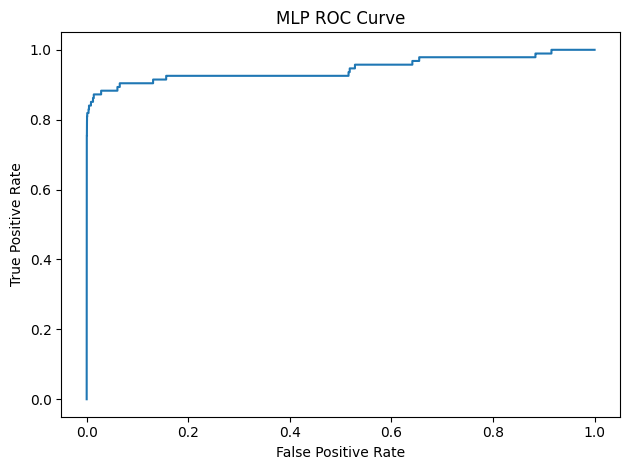

In [52]:
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_preds)
print('MLP AUC =', auc(fpr_mlp, tpr_mlp))

plt.plot(fpr_mlp, tpr_mlp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP ROC Curve")
plt.grid(False)
plt.tight_layout()
plt.show()

Our MLP achieved an AUC of 0.9452, which makes it the most performant model of all algorithms we explored.